In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
from bisect import bisect_left, bisect_right
import seaborn as sns
from sklearn.linear_model import LinearRegression
from pylab import rcParams
from itertools import product
import warnings

## 1.
Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. Не используйте данные за последний имеющийся месяц — июнь 2016! Создайте регрессионные признаки для учёта сезонностей и трендов.

In [2]:
df = pd.read_csv('data_1332.csv', index_col = 0)
df.columns = ['npickups']
df.index = pd.date_range('2015-12', '2016-05-31-23', freq = 'h')
df['nhr'] = range(1,df.shape[0]+1)

Определим функцию, которая будет вычислять  гармоники.

In [3]:
def trig_fea (function, T, K):
    '''Return array of 'K' sequences of specified trig. functions' values. 'sin' and 'cos' functions alowed.
    T is the length of timevalues array'''
    if function == 'sin':
        func = np.sin
    elif function == 'cos':
        func = np.cos
    else:
        print "Cpecified trig function must be 'sin' or 'cos'."
        return
    f = []
    t = np.arange(1, T+1)
    for i in xrange(1, K+1):
        f.append(1. * func(t * 2 * np.pi * (i + 1) / 168))
    return np.array(f)

## 2
Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

In [4]:
har_scores = []
for i in range(50):
    i+=1
    data = pd.concat([pd.DataFrame(trig_fea(func, df.shape[0], i).T) for func in ['sin','cos']],
                     axis = 'columns')
    data.columns = ['sin_{}'.format(order) for order in range (i)] + \
                   ['cos_{}'.format(order) for order in range (i)]
        
    X = data.values
    y = df.npickups
    estimator = LinearRegression()
    estimator.fit(X, y)
    har_scores.append([i, estimator.score(X,y)])
har_scores = pd.DataFrame(har_scores)
har_scores.columns = ['n_features', 'score']

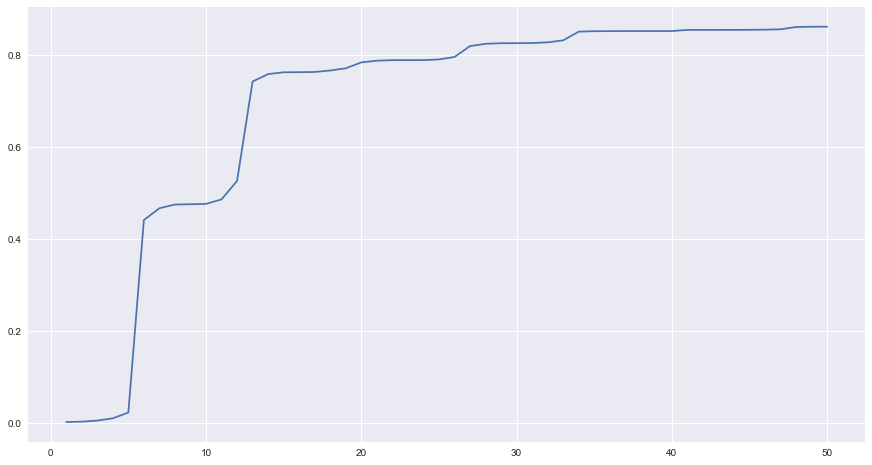

In [5]:
plt.figure(figsize=(15,8))
plt.plot(har_scores.loc[:, 'n_features'], har_scores.loc[:, 'score'])
plt.show()

Как видно из графика, уже на данном этапе можно судить о том, что рекомендованных "для начала" при $K = 2-5$ дополнительных признаков мало. $13$ - гораздо лучше!

In [6]:
order = 13
df_trig = pd.concat([pd.DataFrame(trig_fea(func, df.shape[0], order).T) for func in ['sin','cos']],
                     axis = 'columns')
df_trig.columns =  ['sin_{}'.format(i) for i in range (order)] + \
                   ['cos_{}'.format(i) for i in range (order)]
df_trig.index = df.index
df_trig.head(3)

,sin_0,sin_1,sin_2,sin_3,sin_4,sin_5,sin_6,sin_7,sin_8,sin_9,...,cos_3,cos_4,cos_5,cos_6,cos_7,cos_8,cos_9,cos_10,cos_11,cos_12
2015-12-01 00:00:00,0.074730,0.111964,0.149042,0.185912,0.222521,0.258819,0.294755,0.330279,0.365341,0.399892,...,0.982566,0.974928,0.965926,0.955573,0.943883,0.930874,0.916562,0.900969,0.884115,8.660254e-01
2015-12-01 01:00:00,0.149042,0.222521,0.294755,0.365341,0.433884,0.500000,0.563320,0.623490,0.680173,0.733052,...,0.930874,0.900969,0.866025,0.826239,0.781831,0.733052,0.680173,0.623490,0.563320,5.000000e-01
2015-12-01 02:00:00,0.222521,0.330279,0.433884,0.532032,0.623490,0.707107,0.781831,0.846724,0.900969,0.943883,...,0.846724,0.781831,0.707107,0.623490,0.532032,0.433884,0.330279,0.222521,0.111964,6.123234e-17


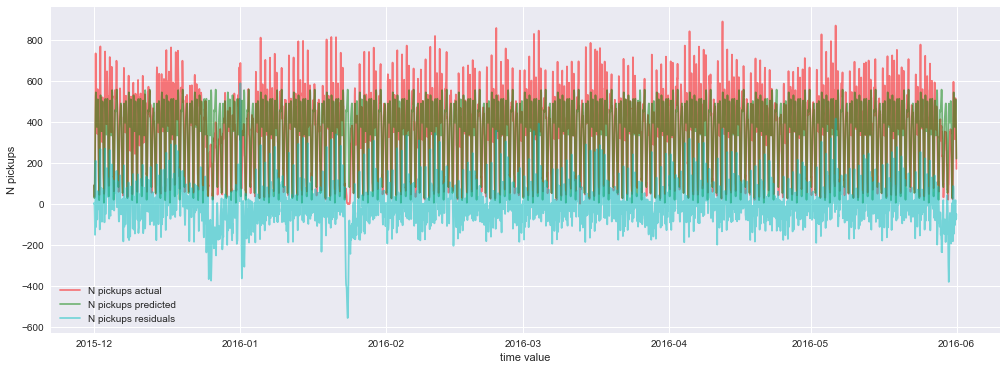

In [7]:
prediction  = LinearRegression().fit(df_trig.values, df.npickups).predict(df_trig.values)
df['resid'] = df.npickups - prediction
df['pred']  = prediction
    
plt.figure(figsize=(17,6))
plt.plot(df.npickups,  'r-', alpha = 0.5, label = 'N pickups actual')
plt.plot(df.pred,      'g-', alpha = 0.5, label = 'N pickups predicted')
plt.plot(df.resid,     'c-', alpha = 0.5, label = 'N pickups residuals')
plt.xlabel('time value')
plt.ylabel('N pickups')
plt.legend()
plt.show()

In [8]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 3. 
Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

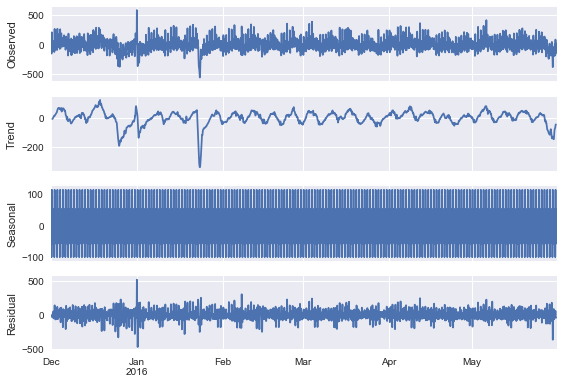

In [9]:
plt.figure(figsize = (18, 10))
sm.tsa.seasonal_decompose(df.resid).plot()
plt.show()

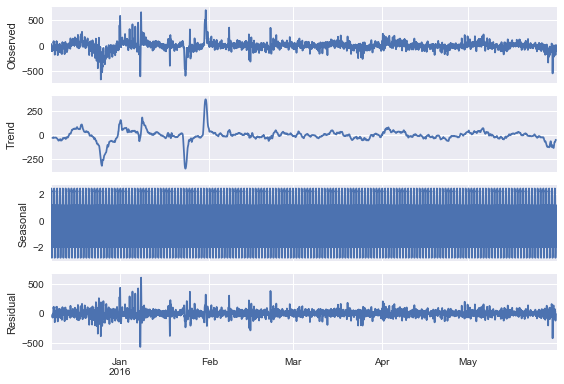

Критерий Дики-Фуллера: p=0.000000


In [10]:
df['resid_diff_1'] = df['resid']        - df['resid'].shift(24 * 7)
sm.tsa.seasonal_decompose(df.loc[df.index[24*7:], 'resid_diff_1']).plot()
plt.figure(figsize=(18,10))
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.loc[df.index[24*7:], 'resid_diff_1'])[1])

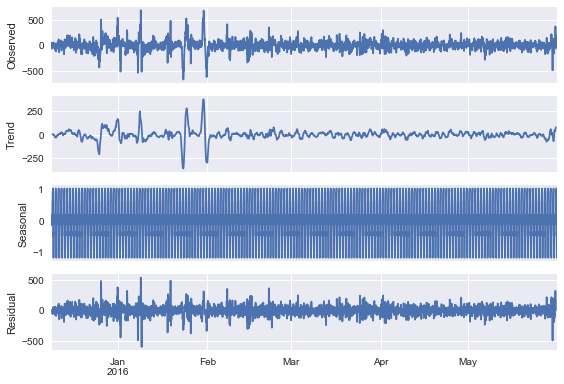

Критерий Дики-Фуллера: p=0.000000


In [11]:
df['resid_diff_2'] = df['resid_diff_1'] - df['resid_diff_1'].shift(24) 
plt.figure(figsize=(18,10))
sm.tsa.seasonal_decompose(df.loc[df.index[24*7 + 24:], 'resid_diff_2']).plot()
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.loc[df.index[24*7 + 24:], 'resid_diff_2'])[1])

Теперь, когда тренд и остатки (остатки остатков, точнее), по крайней мере визуально, избавились от сезонных колебаний, определим начальные значения гиперпараметров ARIMAX.

## 4. 
Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p,q,P,Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

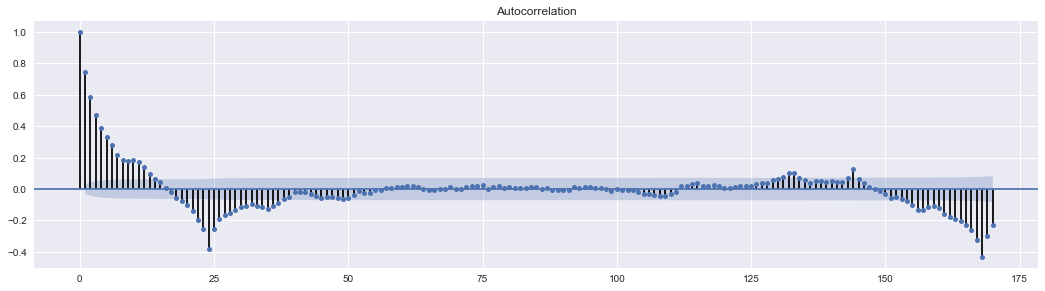

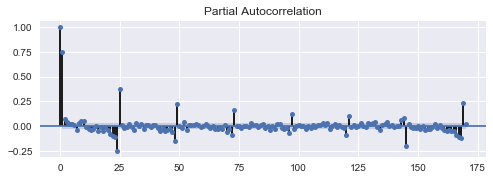

In [12]:
plt.figure(figsize=(18,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.loc[df.index[24*7 + 24:], 'resid_diff_2'].values.squeeze(), lags=170, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.loc[df.index[24*7 + 24:], 'resid_diff_2'].values.squeeze(), lags=170, ax=ax)
plt.show()

Начальное значение для параметра $Q  ∗  $S даёт номер последнего сезонного лага, при котором автокорреляция значима. В нашем примере значение $Q$ составит $168 / (24 * 7)$ в первом приближении, то есть 1.
Параметр $q$ задаётся номером последнего несезонного лага, при котором автокорреляция значима, в нашем случае - 12.

Начальное приближение для параметра $P ∗$S задаёт номер последнего сезонного лага, при котором частичная автокорреляция значима. В данных это лаг под номером 168, значит начальное приближение $P = 1$, поскольку длина сезонного периода $S = 168$. Аналогично, p задаётся как номер последнего несезонного лага, при котором частичная автокорреляция значима. В данном случае можно взять начальное приближение $p = 1$.

In [13]:
p, d, q, P, D, Q = 2, 1, 1, 1, 1, 1
ps = range(0, p+1 )
qs = range(0, q+1 )
Ps = range(0, P+1)
Qs = range(1, Q+1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print 'Для перебора выбрано  {} варианта.'.format(len(parameters_list))

Для перебора выбрано  12 варианта.


In [14]:
df_trig_cut = df_trig.loc['2016-01':'2016-06']
df_cut = df.loc['2016-01':'2016-06']

In [29]:
import time
from scipy.linalg import LinAlgError

In [45]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
exog = sm.add_constant(df_trig_cut.loc[:, ['sin_0', 'sin_1', 'cos_0', 'cos_1']])

for param in parameters_list:
    now = time.time()
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog = df_cut.loc[:, 'npickups'].astype('float'), 
                                        order=         (param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24),
                                        exog = exog).fit(disp=-1)
        
        print('Ok parameters:', param, '   time duration, min: ', round(float(time.time() - now) / 60))
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError:
        print('Singular matrix:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('Ok parameters:', (0, 0, 0, 1), '   time duration, min: ', 0.0)
('Ok parameters:', (0, 0, 1, 1), '   time duration, min: ', 1.0)
('Ok parameters:', (0, 1, 0, 1), '   time duration, min: ', 1.0)
('Ok parameters:', (0, 1, 1, 1), '   time duration, min: ', 1.0)
('Ok parameters:', (1, 0, 0, 1), '   time duration, min: ', 1.0)
('Ok parameters:', (1, 0, 1, 1), '   time duration, min: ', 1.0)
('Ok parameters:', (1, 1, 0, 1), '   time duration, min: ', 1.0)
('Ok parameters:', (1, 1, 1, 1), '   time duration, min: ', 1.0)
Wall time: 5min 42s


## 5.
Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов K или поменять порядки дифференцирования.

In [46]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters           aic
7  (1, 1, 1, 1)  39654.843926
3  (0, 1, 1, 1)  39655.352502
5  (1, 0, 1, 1)  39701.813385
1  (0, 0, 1, 1)  39878.934966
2  (0, 1, 0, 1)  39896.471304


In [47]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           npickups   No. Observations:                 3648
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -19817.422
Date:                            Tue, 10 Oct 2017   AIC                          39654.844
Time:                                    09:05:08   BIC                          39716.863
Sample:                                01-01-2016   HQIC                         39676.931
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.171e-05   2.11e+04  -1.98e-09      1.000   -4.14e+04    4.14e+04
sin_0         11.5348     22.251   

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


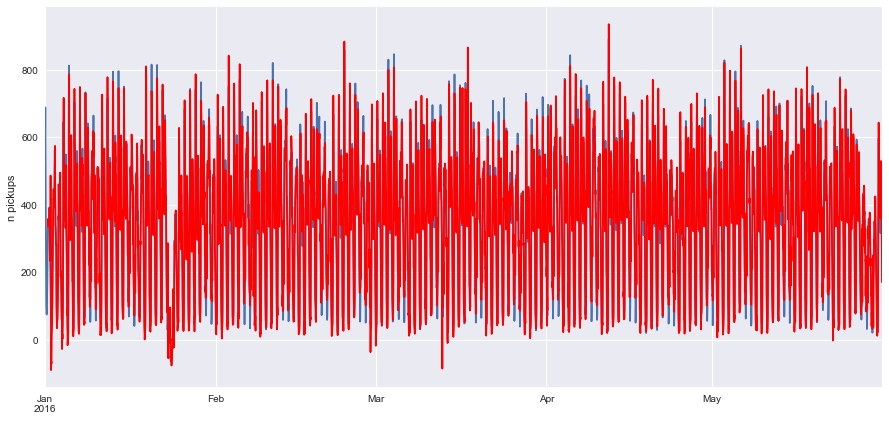

In [48]:
df_cut['model_01'] = best_model.fittedvalues
plt.figure(figsize=(15,7))
df_cut.npickups.plot()
df_cut.model_01[13:].plot(color='r')
plt.ylabel('n pickups')
plt.show()

Попробуем улучшить модель, добавив признаки.

In [72]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
exog = sm.add_constant(df_trig_cut.loc[:, ['sin_0', 'sin_1', 'sin_2', 'sin_3',
                                           'cos_0', 'cos_1', 'cos_2', 'cos_3']])

for param in parameters_list:
    now = time.time()
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog = df_cut.loc[:, 'npickups'].astype('float'), 
                                        order=         (param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24),
                                        exog = exog).fit(disp=-1)
        
        print('Ok parameters:', param, '   time duration, min: ', round(float(time.time() - now) / 60))
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError:
        print('Singular matrix:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('Ok parameters:', (0, 0, 0, 1), '   time duration, min: ', 1.0)
('Ok parameters:', (0, 0, 1, 1), '   time duration, min: ', 1.0)
('Ok parameters:', (0, 1, 0, 1), '   time duration, min: ', 1.0)
('Ok parameters:', (0, 1, 1, 1), '   time duration, min: ', 1.0)
('Ok parameters:', (1, 0, 0, 1), '   time duration, min: ', 1.0)
('Ok parameters:', (1, 0, 1, 1), '   time duration, min: ', 1.0)
('Ok parameters:', (1, 1, 0, 1), '   time duration, min: ', 1.0)
('Ok parameters:', (1, 1, 1, 1), '   time duration, min: ', 1.0)
Wall time: 6min 18s


In [73]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           npickups   No. Observations:                 3648
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -19813.921
Date:                            Tue, 10 Oct 2017   AIC                          39655.841
Time:                                    10:55:48   BIC                          39742.668
Sample:                                01-01-2016   HQIC                         39686.764
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -3.39e-05   2.18e+04  -1.55e-09      1.000   -4.28e+04    4.28e+04
sin_0         11.7436     22.729   

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


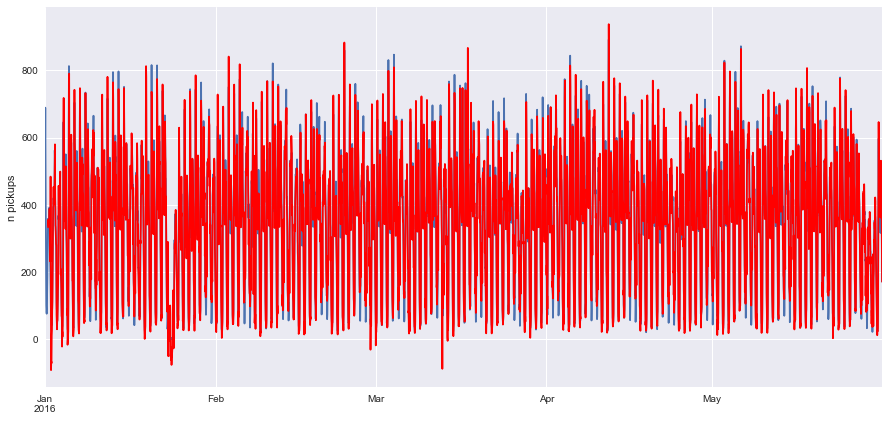

In [74]:
df_cut['model_02'] = best_model.fittedvalues
plt.figure(figsize=(15,7))
df_cut.npickups.plot()
df_cut.model_02[13:].plot(color='r')
plt.ylabel('n pickups')
plt.show()

По значению AIC видим, что качество не улучшилось.

## 6.
Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


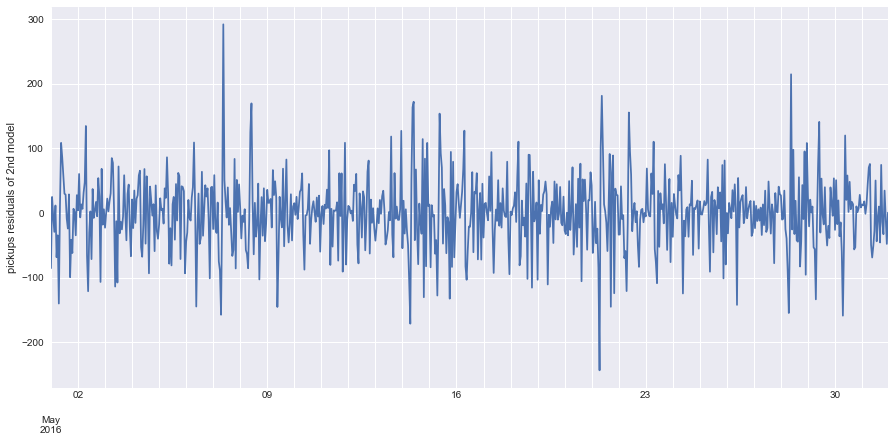

In [75]:
df_cut['resid_01'] = df_cut.npickups - df_cut.model_01
plt.figure(figsize=(15,7))
df_cut.loc['2016-05','resid_02'].plot()
plt.ylabel('pickups residuals of 2nd model')
plt.xticks(pd.date_range('2016-05-01', '2016-05-31', freq = 'D'))
plt.show()

Видно, что модель сильнее всего ошибается в ночной период между субботами и воскресеньями. В это время остатки максимальны.

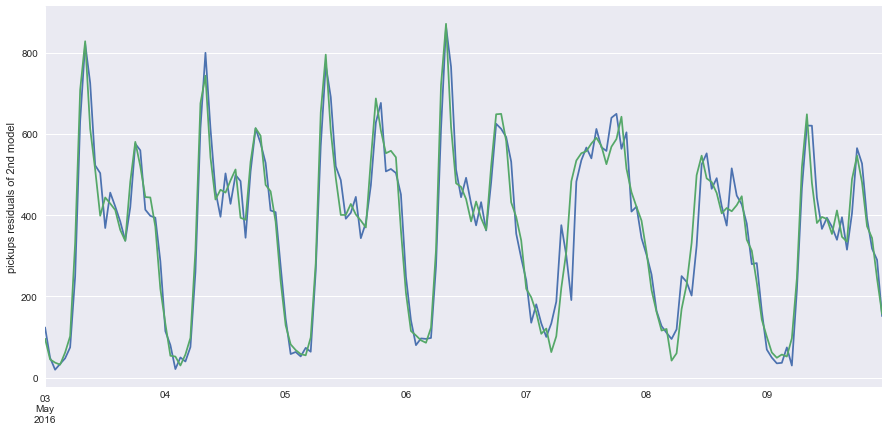

In [78]:
plt.figure(figsize=(15,7))
df_cut.loc['2016-05-03':'2016-05-09','model_01'].plot()
df_cut.loc['2016-05-03':'2016-05-09','npickups'].plot()
plt.ylabel('pickups residuals of 2nd model')
plt.show()

7 и 8 мая как раз были суббота и воскресенье, на срезе видно, что невязки там выше, чем в другие дни.

## 7.
Загрузите ноутбук в форму.